https://scikit-learn.org/stable/modules/grid_search.html#multimetric-grid-search 

In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_classification, make_blobs
from sklearn.datasets import load_iris
from sklearn.datasets import load_digits
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.ensemble import GradientBoostingClassifier
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.svm import LinearSVC
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import validation_curve
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold


from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
#from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


from matplotlib.colors import ListedColormap

#from adspy_shared_utilities import plot_feature_importances
#from adspy_shared_utilities import plot_decision_tree
#from adspy_shared_utilities import plot_class_regions_for_classifier
#from adspy_shared_utilities import plot_class_regions_for_classifier_subplot
#from adspy_shared_utilities import plot_fruit_knn

---
FRUIT (4 class dataset)
---
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html#sphx-glr-auto-examples-model-selection-plot-grid-search-digits-py

In [2]:
from sklearn import metrics
print (sorted(metrics.SCORERS.keys()) )

['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'neg_root_mean_squared_error', 'normalized_mutual_info_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'rand_score', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'roc_auc_ovo', 'roc_auc_ovo_weighted', 'roc_auc_ovr', 'roc_auc_ovr_weighted', 'top_k_accuracy', 'v_measure_score']


In [3]:
# fruits dataset
fruits = pd.read_table('fruit_data_with_colors.txt')
print (pd.DataFrame(fruits).info())

feature_names_fruits = ['height', 'width', 'mass', 'color_score']
X_fruits = fruits[feature_names_fruits]
y_fruits = fruits['fruit_label']

print (X_fruits.head())
print(y_fruits.head())

target_names_fruits = ['apple', 'mandarin', 'orange', 'lemon']

X_fruits_2d = fruits[['height', 'width']]
y_fruits_2d = fruits['fruit_label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   fruit_label    59 non-null     int64  
 1   fruit_name     59 non-null     object 
 2   fruit_subtype  59 non-null     object 
 3   mass           59 non-null     int64  
 4   width          59 non-null     float64
 5   height         59 non-null     float64
 6   color_score    59 non-null     float64
dtypes: float64(3), int64(2), object(2)
memory usage: 3.4+ KB
None
   height  width  mass  color_score
0     7.3    8.4   192         0.55
1     6.8    8.0   180         0.59
2     7.2    7.4   176         0.60
3     4.7    6.2    86         0.80
4     4.6    6.0    84         0.79
0    1
1    1
2    1
3    2
4    2
Name: fruit_label, dtype: int64


In [4]:
# Split the dataset in two equal parts
targets = y_fruits
X_train, X_test, y_train, y_test = train_test_split(X_fruits,
                                                    y_fruits, 
                                                    test_size=0.5, # defaults to .75
                                                    stratify=targets,# consistent class distribution between train and test sets 
                                                    random_state=0)

print('y_train class distribution')
print(y_train.value_counts(normalize=True))
print('y_test class distribution')
print(y_test.value_counts(normalize=True))

y_train class distribution
3    0.310345
1    0.310345
4    0.275862
2    0.103448
Name: fruit_label, dtype: float64
y_test class distribution
1    0.333333
3    0.333333
4    0.266667
2    0.066667
Name: fruit_label, dtype: float64


In [5]:
# Set the parameters by cross-validation
tuned_parameters = [
    {"kernel": ["rbf"], "gamma": [1e-2, 1e-3, 1e-4], "C": [0.01, 0.1,1, 10, 100, 1000]},
    {"kernel": ["linear"], "C": [1, 10, 100, 1000]},
]

# "Remove roc_auc if it is multi class. 
# They do not play well together. Use default scoring or choose something else."

# The scorers can be either one of the predefined metric strings or a scorer
# callable, like the one returned by make_scorer
#scoring = {"AUC": "roc_auc", "Accuracy": make_scorer(accuracy_score)}
#scores = {
#    'precision': make_scorer(precision_score, zero_division=0) # limit the number of false positives
    #'recall_score': make_scorer(recall_score),
    #'accuracy_score': make_scorer(accuracy_score)}
scores = ["precision", "recall", "f1"]

for score in scores:
    print ("-----------------------------------------------------------------")
    print (score)
    print("# ...Tuning hyper-parameters for %s" % score)
    print()
    clf = GridSearchCV(SVC(), 
                       tuned_parameters, 
                       return_train_score=True, # computationaly expensive, not strictly required. defaults to False
                       refit = "f1", 
                       scoring="%s_weighted" % score, #scoring="%s_micro" % score, #scoring="%s_macro" % score, 
                       n_jobs = -1,
                       error_score = "raise")
                     
    clf.fit(X_train, y_train)
    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_["mean_test_score"]
    stds = clf.cv_results_["std_test_score"]
    for mean, std, params in zip(means, stds, clf.cv_results_["params"]):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred, 
                                zero_division=0) )
    print()

# Note the problem is too easy: the hyperparameter plateau is too flat and the
# output model is the same for precision and recall with ties in quality.

-----------------------------------------------------------------
precision
# ...Tuning hyper-parameters for precision



/Users/corinapostelnicu/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Best parameters set found on development set:

{'C': 100, 'kernel': 'linear'}

Grid scores on development set:

0.332 (+/-0.410) for {'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}
0.287 (+/-0.214) for {'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}
0.159 (+/-0.158) for {'C': 0.01, 'gamma': 0.0001, 'kernel': 'rbf'}
0.332 (+/-0.410) for {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
0.287 (+/-0.214) for {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
0.159 (+/-0.158) for {'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.518 (+/-0.587) for {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
0.582 (+/-0.547) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.230 (+/-0.281) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.518 (+/-0.534) for {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
0.540 (+/-0.557) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.424 (+/-0.325) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.433 (+/-0.392) for {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
0.601 (+/-0.560) for {'C': 100, 'gamma': 0.001, 'k

/Users/corinapostelnicu/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Best parameters set found on development set:

{'C': 100, 'kernel': 'linear'}

Grid scores on development set:

0.433 (+/-0.499) for {'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}
0.440 (+/-0.240) for {'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}
0.373 (+/-0.229) for {'C': 0.01, 'gamma': 0.0001, 'kernel': 'rbf'}
0.433 (+/-0.499) for {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
0.440 (+/-0.240) for {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
0.373 (+/-0.229) for {'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.507 (+/-0.453) for {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
0.580 (+/-0.371) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.407 (+/-0.244) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.507 (+/-0.453) for {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
0.540 (+/-0.470) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.513 (+/-0.272) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.513 (+/-0.272) for {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
0.540 (+/-0.470) for {'C': 100, 'gamma': 0.001, 'k

/Users/corinapostelnicu/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Best parameters set found on development set:

{'C': 100, 'kernel': 'linear'}

Grid scores on development set:

0.358 (+/-0.432) for {'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}
0.338 (+/-0.216) for {'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}
0.221 (+/-0.198) for {'C': 0.01, 'gamma': 0.0001, 'kernel': 'rbf'}
0.358 (+/-0.432) for {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
0.338 (+/-0.216) for {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
0.221 (+/-0.198) for {'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.484 (+/-0.470) for {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
0.551 (+/-0.428) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.270 (+/-0.238) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.496 (+/-0.470) for {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
0.522 (+/-0.488) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.440 (+/-0.303) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.447 (+/-0.337) for {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
0.538 (+/-0.465) for {'C': 100, 'gamma': 0.001, 'k

---
EVALUATION OF THE TUNED MODELS ==> CROSSVALIDATION
---

In [6]:
number_crossval_folds = 5
skf = StratifiedKFold(n_splits=3)
# recall  / precision {'C': 1, 'kernel': 'linear'}
clf = SVC(C= 1, 
          kernel = 'linear')

# Evaluate a score by cross-validation
cv_scores = cross_val_score(clf, 
                            X_fruits, y_fruits, 
                            cv = skf, #cv= number_crossval_folds,
                            scoring = "accuracy")

print ( str(number_crossval_folds) +" - fold")
print('Cross-validation scores:', cv_scores)
print('Mean cross-validation score: {:.3f}'
     .format(np.mean(cv_scores)))

5 - fold
Cross-validation scores: [0.7        0.8        0.73684211]
Mean cross-validation score: 0.746


In [7]:
print (sorted(metrics.SCORERS.keys()) )

['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'neg_root_mean_squared_error', 'normalized_mutual_info_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'rand_score', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'roc_auc_ovo', 'roc_auc_ovo_weighted', 'roc_auc_ovr', 'roc_auc_ovr_weighted', 'top_k_accuracy', 'v_measure_score']


In [8]:
# run cross-validation on multiple metrics and also to return train scores, fit times and score times.
cv_results = cross_validate(clf, 
                            X_fruits, y_fruits, 
                            cv=number_crossval_folds, 
                            scoring=('accuracy', 'precision_macro', 'recall_macro', "f1_macro"))
sorted(cv_results.keys())
cv_results

{'fit_time': array([0.0167551 , 0.00960898, 0.01234365, 0.01049018, 0.0066359 ]),
 'score_time': array([0.0191009 , 0.01505423, 0.00811911, 0.00491476, 0.00479007]),
 'test_accuracy': array([0.83333333, 0.83333333, 0.83333333, 0.83333333, 0.81818182]),
 'test_precision_macro': array([0.875     , 0.91666667, 0.875     , 0.85416667, 0.85416667]),
 'test_recall_macro': array([0.875     , 0.875     , 0.875     , 0.85416667, 0.85416667]),
 'test_f1_macro': array([0.875     , 0.86666667, 0.875     , 0.85416667, 0.85416667])}

    Results on classifier fit with best params found via grid search

<IPython.core.display.Javascript object>


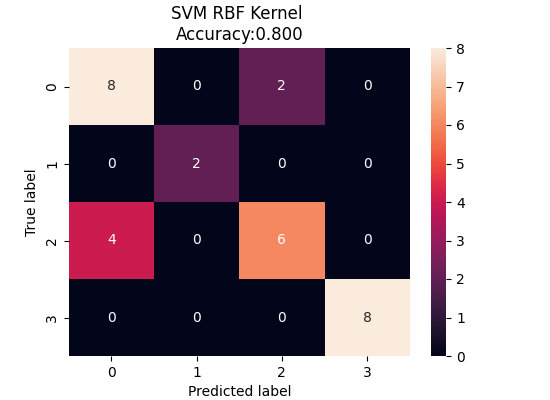


------------------------------------------
              precision    recall  f1-score   support

           1       0.67      0.80      0.73        10
           2       1.00      1.00      1.00         2
           3       0.75      0.60      0.67        10
           4       1.00      1.00      1.00         8

    accuracy                           0.80        30
   macro avg       0.85      0.85      0.85        30
weighted avg       0.81      0.80      0.80        30



In [9]:
clf = SVC(C= 1, 
          kernel = 'linear',
          probability = True).fit(X_train, 
                                 y_train)

predictions = clf.predict(X_test)
confusion = confusion_matrix(y_test, 
                             predictions)

confusionmatrix_df = pd.DataFrame(confusion, 
                     index = [i for i in range(0,len(y_fruits.unique()))],
                     columns = [i for i in range(0,len(y_fruits.unique()))])

plt.figure(figsize = (5.5,4))
sns.heatmap(confusionmatrix_df, annot=True)
plt.title('SVM RBF Kernel \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, 
                                                                    predictions)))
plt.ylabel('True label')
plt.xlabel('Predicted label');

print ("")
print ("------------------------------------------")

# Combined report with all  metrics
print(classification_report(y_test, 
                            predictions
                           ))

In [10]:
# predicted probability of class membership
y_proba_clf = clf.predict_proba(X_test)
y_proba_list = list(zip(y_test[0:10], y_proba_clf[0:10,1]))

# show the probability of positive class for first 10 instances
y_proba_list

[(1, 0.05692247783099837),
 (4, 0.15418203487367135),
 (4, 0.09844045373357725),
 (3, 7.962676189913189e-05),
 (3, 0.052897835520116614),
 (4, 0.14486334409368748),
 (1, 0.03261403586745997),
 (1, 0.04087118786137204),
 (1, 0.03479102973836825),
 (3, 0.08186380572680195)]

In [11]:
y_scores_clf = clf.decision_function(X_test)
y_score_list = list(zip(y_test[0:20], y_scores_clf[0:20]))
# show the decision_function scores for first 20 instances
y_score_list_df = pd.DataFrame(y_score_list)
y_score_list_df.columns = ["target", "decision function score"]
y_score_list_df.head()
# y_score_list_df.loc[0,:]["decision function score"]

,target,decision function score
0,1,"[3.2451908391448083, -0.27956159613100556, 2.2..."
1,4,"[0.7333320966486421, -0.19100791832150948, 2.1..."
2,4,"[0.7356447913974736, -0.24338783362607933, 2.1..."
3,3,"[2.298508631493762, -0.3213366855975807, 3.312..."
4,3,"[3.240365725191949, -0.2814495716320385, 2.246..."


In [12]:
print('Accuracy = {:.2f}'
      .format(accuracy_score(y_test, predictions)))
print('Micro-averaged recall = {:.2f} (treat instances equally)'
      .format(recall_score(y_test, predictions, average = 'micro')))
print('Macro-averaged recall = {:.2f} (treat classes equally)'
      .format(recall_score(y_test, predictions, average = 'macro')))
print('Micro-averaged precision = {:.2f} (treat instances equally)'
      .format(precision_score(y_test, predictions, average = 'micro')))
print('Macro-averaged precision = {:.2f} (treat classes equally)'
      .format(precision_score(y_test, predictions, average = 'macro')))

print('Micro-averaged f1 = {:.2f} (treat instances equally)'
      .format(f1_score(y_test, predictions, average = 'micro')))
print('Macro-averaged f1 = {:.2f} (treat classes equally)'
      .format(f1_score(y_test, predictions, average = 'macro')))

Accuracy = 0.80
Micro-averaged recall = 0.80 (treat instances equally)
Macro-averaged recall = 0.85 (treat classes equally)
Micro-averaged precision = 0.80 (treat instances equally)
Macro-averaged precision = 0.85 (treat classes equally)
Micro-averaged f1 = 0.80 (treat instances equally)
Macro-averaged f1 = 0.85 (treat classes equally)


    CAN ONLY RUN FOR BINARY CLASSIFICATION